In [1]:
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import tensorflow as tf
from sklearn.metrics import confusion_matrix, classification_report
from tensorflow.keras import Sequential
from tensorflow import keras
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPooling2D
from tensorflow.keras import layers, models, regularizers, callbacks, optimizers

In [2]:
train = "D:/Datasets/Emotion Based/KDEF/KDEF/Train"
test = "D:/Datasets/Emotion Based/KDEF/KDEF/Test"

In [3]:
image_size = (256, 256)
batch_size = 32

In [4]:
data_augmentation = tf.keras.Sequential([
    layers.RandomFlip("horizontal"),
    layers.RandomRotation(0.1),
    layers.RandomZoom(0.2),
    layers.RandomContrast(0.2),
])

In [5]:
train_set = keras.utils.image_dataset_from_directory(
    train, 
    image_size=image_size,
    batch_size=batch_size,
    label_mode="binary",
    seed=42, 
    validation_split=0.2,
    subset='training'
)

Found 4409 files belonging to 2 classes.
Using 3528 files for training.


In [6]:
valid_set = keras.utils.image_dataset_from_directory(
    train,
    image_size=image_size,
    batch_size=batch_size,
    label_mode="binary",
    seed=42,
    validation_split=0.2,
    subset='validation'
)

Found 4409 files belonging to 2 classes.
Using 881 files for validation.


In [7]:
test_set = tf.keras.utils.image_dataset_from_directory(
    test,
    image_size=image_size,
    batch_size=batch_size,
    label_mode='binary',
    shuffle=False,
    seed=42
)

Found 1891 files belonging to 2 classes.


In [8]:
class_counts = np.concatenate([y for X, y in train_set], axis=0)
total = len(class_counts)
weight_for_0 = (1 / np.sum(class_counts == 0)) * (total / 2.0)
weight_for_1 = (1 / np.sum(class_counts == 1)) * (total / 2.0)
class_weight = {0: weight_for_0, 1: weight_for_1}

print(f"\nClass Weights: 0 -> {weight_for_0:.2f}, 1 -> {weight_for_1:.2f}")



Class Weights: 0 -> 1.12, 1 -> 0.90


In [9]:
model = models.Sequential([
        layers.Input(shape=(*image_size, 3)),
        data_augmentation,
        layers.Rescaling(1./255),
        
        # Conv Block 1
        layers.Conv2D(64, 3, activation='relu', padding='same'),
        layers.Conv2D(64, 3, activation='relu', padding='same'),
        layers.MaxPooling2D(2),
        layers.BatchNormalization(),
        
        # Conv Block 2
        layers.Conv2D(128, 3, activation='relu', padding='same'),
        layers.Conv2D(128, 3, activation='relu', padding='same'),
        layers.MaxPooling2D(2),
        layers.BatchNormalization(),
        
        # Conv Block 3
        layers.Conv2D(256, 3, activation='relu', padding='same'),
        layers.Conv2D(256, 3, activation='relu', padding='same'),
        layers.MaxPooling2D(2),
        layers.BatchNormalization(),
        
        # Head
        layers.Flatten(),
        layers.Dense(512, activation='relu', kernel_regularizer=regularizers.l2(1e-4)),
        layers.Dropout(0.5),
        layers.BatchNormalization(),
        
        layers.Dense(256, activation='relu', kernel_regularizer=regularizers.l2(1e-4)),
        layers.Dropout(0.3),
        layers.BatchNormalization(),
        
        layers.Dense(1, activation='sigmoid')
    ])

In [10]:
model.compile(
    optimizer=optimizers.AdamW(learning_rate=1e-4, weight_decay=1e-4),
    loss='binary_crossentropy',
    metrics=[
        'accuracy',
        tf.keras.metrics.Precision(name='precision'),
        tf.keras.metrics.Recall(name='recall')
    ]
)

In [11]:
model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ sequential (Sequential)         │ (None, 256, 256, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ rescaling (Rescaling)           │ (None, 256, 256, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 256, 256, 64)   │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 256, 256, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 128, 128, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 128, 128, 64)   │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 128, 128, 128)  │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 128, 128, 128)  │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 64, 64, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 64, 64, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 64, 64, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 64, 64, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 32, 32, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 32, 32, 256)    │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 262144)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 512)            │   134,218,240 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 512)            │         2,048 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 256)            │       131,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 256)            │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 1)              │           257 │
└─────────────────────────────────┴────────────────────────┴─────────────

 Total params: 135,500,097 (516.89 MB)

 Trainable params: 135,497,665 (516.88 MB)

 Non-trainable params: 2,432 (9.50 KB)

In [12]:
early_stop = callbacks.EarlyStopping(
    monitor='val_loss',
    patience=12,
    restore_best_weights=True
)

In [13]:
lr_scheduler = callbacks.ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.2,
    patience=5,
    min_lr=1e-6
)

In [14]:
history = model.fit(
    train_set,
    validation_data=valid_set,
    epochs=100,
    class_weight=class_weight,
    callbacks=[early_stop, lr_scheduler],
    verbose=1
)

Epoch 1/100


111/111 ━━━━━━━━━━━━━━━━━━━━ 2248s 20s/step - accuracy: 0.6968 - loss: 0.7722 - precision: 0.6895 - recall: 0.7831 - val_accuracy: 0.5664 - val_loss: 0.8594 - val_precision: 0.5664 - val_recall: 1.0000 - learning_rate: 1.0000e-04
Epoch 2/100
111/111 ━━━━━━━━━━━━━━━━━━━━ 1739s 16s/step - accuracy: 0.7059 - loss: 0.7652 - precision: 0.6975 - recall: 0.7935 - val_accuracy: 0.5664 - val_loss: 0.9243 - val_precision: 0.5664 - val_recall: 1.0000 - learning_rate: 1.0000e-04
Epoch 3/100
111/111 ━━━━━━━━━━━━━━━━━━━━ 1731s 16s/step - accuracy: 0.6989 - loss: 0.7333 - precision: 0.6841 - recall: 0.7996 - val_accuracy: 0.3099 - val_loss: 1.1177 - val_precision: 0.3661 - val_recall: 0.2986 - learning_rate: 1.0000e-04
Epoch 4/100
111/111 ━━━━━━━━━━━━━━━━━━━━ 1725s 16s/step - accuracy: 0.7035 - loss: 0.7433 - precision: 0.7077 - recall: 0.7659 - val_accuracy: 0.5664 - val_loss: 0.8740 - val_precision: 0.5664 - val_recall: 1.0000 - learning_rate: 1.0000e-04
Epoch 5/100
111/111 ━━━━━━━━━━━━━━━━━━━━ 170

In [15]:
test_loss, test_acc, test_precision, test_recall = model.evaluate(test_set)
print(f"\nStandard Evaluation:")
print(f"Accuracy: {test_acc*100:.2f}%")
print(f"Precision: {test_precision:.3f}")
print(f"Recall: {test_recall:.3f}")


60/60 ━━━━━━━━━━━━━━━━━━━━ 194s 3s/step - accuracy: 0.9259 - loss: 0.2788 - precision: 0.4703 - recall: 0.5500

Standard Evaluation:
Accuracy: 93.60%
Precision: 0.933
Recall: 0.953


In [16]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss =history.history['loss']
val_loss = history.history['val_loss']

<Figure size 640x480 with 0 Axes>

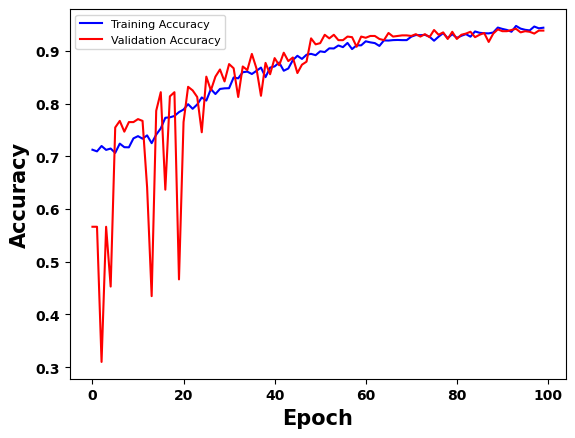

<Figure size 640x480 with 0 Axes>

In [17]:
epochs = range(len(acc))

plt.plot(epochs, acc, 'b', label = 'Training Accuracy')
plt.plot(epochs, val_acc, 'r', label = 'Validation Accuracy')
plt.xlabel("Epoch",fontsize= 15, fontweight='bold')
plt.ylabel("Accuracy",fontsize= 15, fontweight='bold')
plt.xticks(fontsize=10, fontweight='bold')
plt.yticks(fontsize=10, fontweight='bold')
plt.legend(prop={'size': 8})
plt.figure()

<Figure size 640x480 with 0 Axes>

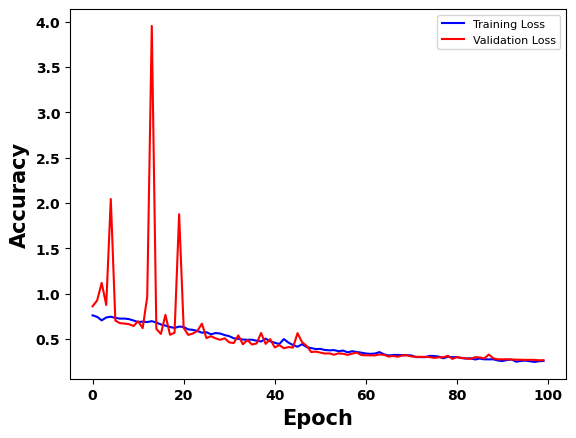

<Figure size 640x480 with 0 Axes>

In [18]:
epochs = range(len(loss))

plt.plot(epochs, loss, 'b', label = 'Training Loss')
plt.plot(epochs, val_loss, 'r', label = 'Validation Loss')
plt.xlabel("Epoch",fontsize= 15, fontweight='bold')
plt.ylabel("Accuracy",fontsize= 15, fontweight='bold')
plt.xticks(fontsize=10, fontweight='bold')
plt.yticks(fontsize=10, fontweight='bold')
plt.legend(prop={'size': 8})
plt.figure()

In [19]:
y_true = np.concatenate([y for X, y in test_set], axis=0)
y_pred = (model.predict(test_set) > 0.5).astype(int)

60/60 ━━━━━━━━━━━━━━━━━━━━ 187s 3s/step


In [20]:
print("\nDetailed Classification Report:")
print(classification_report(y_true, y_pred, target_names=['Class 0', 'Class 1']))


Detailed Classification Report:
              precision    recall  f1-score   support

     Class 0       0.94      0.91      0.93       842
     Class 1       0.93      0.95      0.94      1049

    accuracy                           0.94      1891
   macro avg       0.94      0.93      0.94      1891
weighted avg       0.94      0.94      0.94      1891



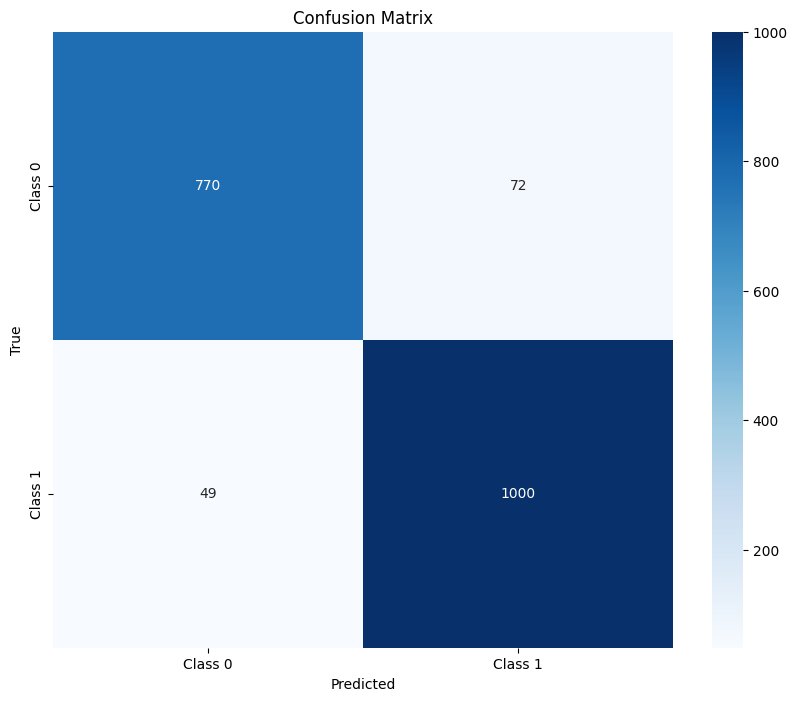

In [21]:
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=['Class 0', 'Class 1'],
            yticklabels=['Class 0', 'Class 1'])
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()